In [1]:
import argparse
import logging
import pickle

import pandas as pd
from sklearn.model_selection import train_test_split

from problem_config import ProblemConfig, ProblemConst, get_prob_config

In [33]:
PHASE1 = "phase-1"
PROB1 = "prob-1"
PROB2 = "prob-2"
prob_config = get_prob_config(PHASE1, PROB2)
#RawDataProcessor.process_raw_data(prob_config)

In [34]:
training_data = pd.read_parquet(prob_config.raw_data_path)

In [35]:
training_data.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,label
0,V1,4.781942,V2,V8,1337.025331,V4,V4,2.0,V2,V0,...,V2,35.689494,none,V1,1.0,V2,1.0,none,yes,0
1,V3,22.764682,V4,V2,1664.415301,V0,V4,4.0,V1,V0,...,V0,23.265980,none,V1,2.0,V2,1.0,none,yes,0
2,V3,7.462099,V2,V3,750.653224,V3,V2,4.0,V2,V0,...,V2,34.060872,stores,V0,1.0,V2,1.0,yes,yes,0
3,V3,23.718364,V4,V7,4829.002078,V4,V2,4.0,V1,V0,...,V3,62.477448,none,V1,2.0,V1,1.0,none,yes,0
4,V3,13.768903,V3,V3,3559.956292,V3,V4,1.0,V1,V0,...,V2,41.999120,bank,V1,1.0,V2,1.0,yes,yes,0


In [36]:
prob_config.categorical_cols

['feature1',
 'feature3',
 'feature4',
 'feature6',
 'feature7',
 'feature8',
 'feature9',
 'feature10',
 'feature11',
 'feature12',
 'feature14',
 'feature15',
 'feature16',
 'feature17',
 'feature19',
 'feature20']

In [37]:
def build_category_features(data, categorical_cols=None):
    if categorical_cols is None:
        categorical_cols = []
    category_index = {}
    if len(categorical_cols) == 0:
        return data, category_index

    df = data.copy()
    # process category features
    for col in categorical_cols:
        df[col] = df[col].astype("category")
        category_index[col] = df[col].cat.categories
        df[col] = df[col].cat.codes
    return df, category_index

In [38]:
training_data, category_index = build_category_features(
    training_data, prob_config.categorical_cols
)

In [40]:
train, dev = train_test_split(
    training_data,
    test_size=prob_config.test_size,
    random_state=prob_config.random_state,
)

with open(prob_config.category_index_path, "wb") as f:
    pickle.dump(category_index, f)

target_col = prob_config.target_col
train_x = train.drop([target_col], axis=1)
train_y = train[[target_col]]
test_x = dev.drop([target_col], axis=1)
test_y = dev[[target_col]]

train_x.to_parquet(prob_config.train_x_path, index=False)
train_y.to_parquet(prob_config.train_y_path, index=False)
test_x.to_parquet(prob_config.test_x_path, index=False)
test_y.to_parquet(prob_config.test_y_path, index=False)

In [46]:
train_x.shape, test_x.shape

((48000, 20), (12000, 20))

In [42]:
train_x.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20
17041,1,38.467571,4,4,7256.313852,0,2,3,2,0,0,2,34.983101,0,0,1,2,1.0,1,1
56973,3,18.639125,0,7,1521.055515,0,3,3,2,0,2,2,33.954892,1,0,2,1,1.0,0,1
2079,3,24.350002,2,4,3709.023924,1,3,1,1,0,2,1,22.691414,1,1,0,2,1.0,1,1
16087,2,5.603978,1,0,955.901255,4,2,3,2,0,3,0,38.584915,0,1,3,2,2.0,0,1
3146,1,12.287105,2,4,638.956046,4,4,3,0,0,3,2,32.284324,1,1,0,1,1.0,0,1


In [43]:
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()

In [53]:
import xgboost as xgb

model_params = {
  "random_state": 132
}

objective = "binary:hinge" # "binary:logistic"
model = xgb.XGBClassifier(objective=objective, **model_params)

In [54]:
model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:hinge', predictor=None, ...)

In [55]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

predictions = model.predict(test_x)
auc_score = roc_auc_score(test_y, predictions)
print('AUC =',auc_score)
f1score = f1_score(test_y, predictions, average='weighted')
print('F1 =',f1score)
confusion_matrix(test_y, predictions)

AUC = 0.7500070769124738
F1 = 0.8027221697265312


array([[7498,  835],
       [1466, 2201]])

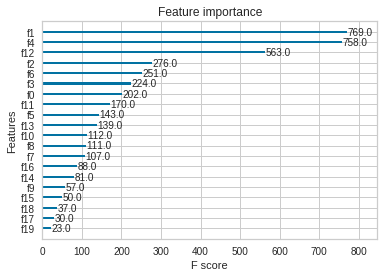

In [64]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
# plot feature importance
plot_importance(model)
plt.show()

In [56]:
from pycaret.classification import *
s = setup(training_data, target = 'label', session_id = 123)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc0add54280>
Traceback (most recent call last):
  File "/home/minh/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/minh/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/minh/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 605, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/home/minh/anaconda3/lib/python3.9/ctypes/__init__.py", line 382, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /home/minh/anaconda3/lib/python3.9/site-packages/numpy.libs/libopenblas64_p-r0-15028c96.3.21.so: cannot open shared object file: No such file or directory


,Description,Value
0,Session id,123
1,Target,label
2,Target type,Binary
3,Original data shape,"(60000, 21)"
4,Transformed data shape,"(60000, 21)"
5,Transformed train set shape,"(42000, 21)"
6,Transformed test set shape,"(18000, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


In [57]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8138,0.8643,0.6134,0.7301,0.6666,0.5388,0.5427,2.8810
lightgbm,Light Gradient Boosting Machine,0.8136,0.8682,0.5967,0.7391,0.6602,0.5338,0.5396,0.5660
gbc,Gradient Boosting Classifier,0.7978,0.8493,0.5367,0.7261,0.6171,0.4839,0.4942,3.2870
rf,Random Forest Classifier,0.7895,0.8338,0.5188,0.7099,0.5994,0.4613,0.4718,2.6150
ada,Ada Boost Classifier,0.7858,0.8292,0.5381,0.6882,0.6039,0.4601,0.4667,0.8950
et,Extra Trees Classifier,0.7839,0.8284,0.5096,0.6973,0.5888,0.4470,0.4572,2.3480
ridge,Ridge Classifier,0.7654,0.0000,0.4487,0.6698,0.5373,0.3883,0.4023,0.0420
lda,Linear Discriminant Analysis,0.7652,0.8023,0.4840,0.6530,0.5558,0.4010,0.4094,0.1230
lr,Logistic Regression,0.7633,0.8002,0.4600,0.6576,0.5412,0.3884,0.3997,1.6720
qda,Quadratic Discriminant Analysis,0.7496,0.7918,0.6349,0.5801,0.6062,0.4232,0.4242,0.0830


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [58]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
class RawDataProcessor:
    @staticmethod
    def build_category_features(data, categorical_cols=None):
        if categorical_cols is None:
            categorical_cols = []
        category_index = {}
        if len(categorical_cols) == 0:
            return data, category_index

        df = data.copy()
        # process category features
        for col in categorical_cols:
            df[col] = df[col].astype("category")
            category_index[col] = df[col].cat.categories
            df[col] = df[col].cat.codes
        return df, category_index

    @staticmethod
    def apply_category_features(
        raw_df, categorical_cols=None, category_index: dict = None
    ):
        if categorical_cols is None:
            categorical_cols = []
        if len(categorical_cols) == 0:
            return raw_df

        apply_df = raw_df.copy()
        for col in categorical_cols:
            apply_df[col] = apply_df[col].astype("category")
            apply_df[col] = pd.Categorical(
                apply_df[col],
                categories=category_index[col],
            ).codes
        return apply_df

    @staticmethod
    def process_raw_data(prob_config: ProblemConfig):
        logging.info("start process_raw_data")
        training_data = pd.read_parquet(prob_config.raw_data_path)
        training_data, category_index = RawDataProcessor.build_category_features(
            training_data, prob_config.categorical_cols
        )
        train, dev = train_test_split(
            training_data,
            test_size=prob_config.test_size,
            random_state=prob_config.random_state,
        )

        with open(prob_config.category_index_path, "wb") as f:
            pickle.dump(category_index, f)

        target_col = prob_config.target_col
        train_x = train.drop([target_col], axis=1)
        train_y = train[[target_col]]
        test_x = dev.drop([target_col], axis=1)
        test_y = dev[[target_col]]

        train_x.to_parquet(prob_config.train_x_path, index=False)
        train_y.to_parquet(prob_config.train_y_path, index=False)
        test_x.to_parquet(prob_config.test_x_path, index=False)
        test_y.to_parquet(prob_config.test_y_path, index=False)
        logging.info("finish process_raw_data")

    @staticmethod
    def load_train_data(prob_config: ProblemConfig):
        train_x_path = prob_config.train_x_path
        train_y_path = prob_config.train_y_path
        train_x = pd.read_parquet(train_x_path)
        train_y = pd.read_parquet(train_y_path)
        return train_x, train_y[prob_config.target_col]

    @staticmethod
    def load_test_data(prob_config: ProblemConfig):
        dev_x_path = prob_config.test_x_path
        dev_y_path = prob_config.test_y_path
        dev_x = pd.read_parquet(dev_x_path)
        dev_y = pd.read_parquet(dev_y_path)
        return dev_x, dev_y[prob_config.target_col]

    @staticmethod
    def load_category_index(prob_config: ProblemConfig):
        with open(prob_config.category_index_path, "rb") as f:
            return pickle.load(f)

    @staticmethod
    def load_capture_data(prob_config: ProblemConfig):
        captured_x_path = prob_config.captured_x_path
        captured_y_path = prob_config.uncertain_y_path
        captured_x = pd.read_parquet(captured_x_path)
        captured_y = pd.read_parquet(captured_y_path)
        return captured_x, captured_y[prob_config.target_col]


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--phase-id", type=str, default=ProblemConst.PHASE1)
    parser.add_argument("--prob-id", type=str, default=ProblemConst.PROB1)
    args = parser.parse_args()

    prob_config = get_prob_config(args.phase_id, args.prob_id)
    RawDataProcessor.process_raw_data(prob_config)